# Exploración de Datos Meteorológicos - Reportes METAR

## Objetivo
Este notebook tiene como objetivo realizar la exploración y análisis exploratorio de datos (EDA) de los datos meteorológicos crudos, incluyendo:
- Análisis exploratorio de datos (EDA)
- Identificación de valores faltantes y anomalías
- Análisis de distribución temporal
- Análisis de variables meteorológicas
- Visualizaciones y estadísticas descriptivas

---

## 1. Importe de librerías

In [1]:
# Importación de librerías necesarias para el análisis y exploración
import pandas as pd  
import numpy as np   
import matplotlib.pyplot as plt  
import seaborn as sns  
import re  

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Librerías importadas correctamente")

Librerías importadas correctamente


---

## 2. Carga de Datos


In [2]:
# Carga de datos crudos desde el archivo CSV
# Estos datos contienen reportes meteorológicos en formato METAR (Meteorological Aerodrome Report)
df_raw = pd.read_csv('../../data/raw/DATOS_CRUDOS.csv')

print(f"Datos cargados correctamente")
print(f"Forma inicial del dataset: {df_raw.shape[0]} filas x {df_raw.shape[1]} columnas")

Datos cargados correctamente
Forma inicial del dataset: 157635 filas x 9 columnas


---

## 3. Análisis Exploratorio de Datos (EDA)

### 3.1 Análisis general del dataset


In [3]:
# Análisis general del dataset: dimensiones, tipos de datos y rango temporal
# Esto nos da una visión inicial de la estructura de los datos

print("=" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 60)

print(f"\n Dimensiones:")
print(f"   Forma del dataset: {df_raw.shape}")
print(f"   Número de registros: {df_raw.shape[0]:,}")
print(f"   Número de columnas: {df_raw.shape[1]}")

# Crear columna de fecha para análisis temporal
if "FECHA_HORA_REPORTE" not in df_raw.columns:
    df_raw["FECHA_HORA_REPORTE"] = pd.to_datetime(df_raw["FECHA_REPORTE"].astype(str), errors='coerce')

print(f"\n Periodo de tiempo:")
print(f"   Fecha mínima: {df_raw['FECHA_HORA_REPORTE'].min()}")
print(f"   Fecha máxima: {df_raw['FECHA_HORA_REPORTE'].max()}")

# Tipos de datos - importante para identificar qué columnas necesitan conversión
print(f"\n Tipos de datos:")
print(df_raw.dtypes)

# Información adicional sobre memoria usada
print(f"\n Uso de memoria: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


INFORMACIÓN GENERAL DEL DATASET

 Dimensiones:
   Forma del dataset: (157635, 9)
   Número de registros: 157,635
   Número de columnas: 9

 Periodo de tiempo:
   Fecha mínima: 1900-01-01 23:59:59
   Fecha máxima: 2025-11-05 13:00:00

 Tipos de datos:
ID_ESTACION                      int64
FECHA_REPORTE                   object
HORA_REPORTE                    object
TIPO_REPORTE                    object
TEXTO_REPORTE                   object
FECHA_INGRESO                   object
CEDULA                         float64
FECHA_HORA_INSERCION            object
BANDERA                         object
FECHA_HORA_REPORTE      datetime64[ns]
dtype: object

 Uso de memoria: 76.25 MB


**Resultados del análisis inicial:**
- El dataset contiene **157,635 registros** con **9 columnas**
- Hay un registro con fecha inválida (1900-01-01) que probablemente es un error
- Las fechas están en formato texto (object), necesitarán conversión a datetime
- La mayoría de columnas son texto (object), lo cual es esperado para reportes METAR


### 3.2 Análisis de valores faltantes

Los valores faltantes pueden afectar significativamente los modelos de predicción, por lo que es crucial identificarlos tempranamente.


In [4]:
# Análisis de valores faltantes en las columnas críticas para el análisis
# Nos enfocamos en FECHA_REPORTE, HORA_REPORTE y TEXTO_REPORTE que son esenciales

columnas_criticas = ["FECHA_REPORTE", "HORA_REPORTE", "TEXTO_REPORTE"]
missing_data = df_raw[columnas_criticas].isna().sum()
missing_percent = (missing_data / len(df_raw)) * 100

missing_df = pd.DataFrame({
    'Valores faltantes': missing_data,
    'Porcentaje': missing_percent
})

print("=" * 60)
print("ANÁLISIS DE VALORES FALTANTES")
print("=" * 60)
print("\nValores faltantes en columnas críticas:")
print(missing_df.to_string())

# Análisis de valores faltantes en todas las columnas
print("\nValores faltantes en todas las columnas:")
null_counts_all = df_raw.isnull().sum()
null_percent_all = (null_counts_all / len(df_raw)) * 100
missing_all_df = pd.DataFrame({
    'Valores faltantes': null_counts_all,
    'Porcentaje': null_percent_all
})
print(missing_all_df.to_string())


ANÁLISIS DE VALORES FALTANTES

Valores faltantes en columnas críticas:
               Valores faltantes  Porcentaje
FECHA_REPORTE                  0         0.0
HORA_REPORTE                   0         0.0
TEXTO_REPORTE                  0         0.0

Valores faltantes en todas las columnas:
                      Valores faltantes  Porcentaje
ID_ESTACION                           0    0.000000
FECHA_REPORTE                         0    0.000000
HORA_REPORTE                          0    0.000000
TIPO_REPORTE                          0    0.000000
TEXTO_REPORTE                         0    0.000000
FECHA_INGRESO                     20674   13.115108
CEDULA                           157593   99.973356
FECHA_HORA_INSERCION              30663   19.451898
BANDERA                               0    0.000000
FECHA_HORA_REPORTE                    0    0.000000


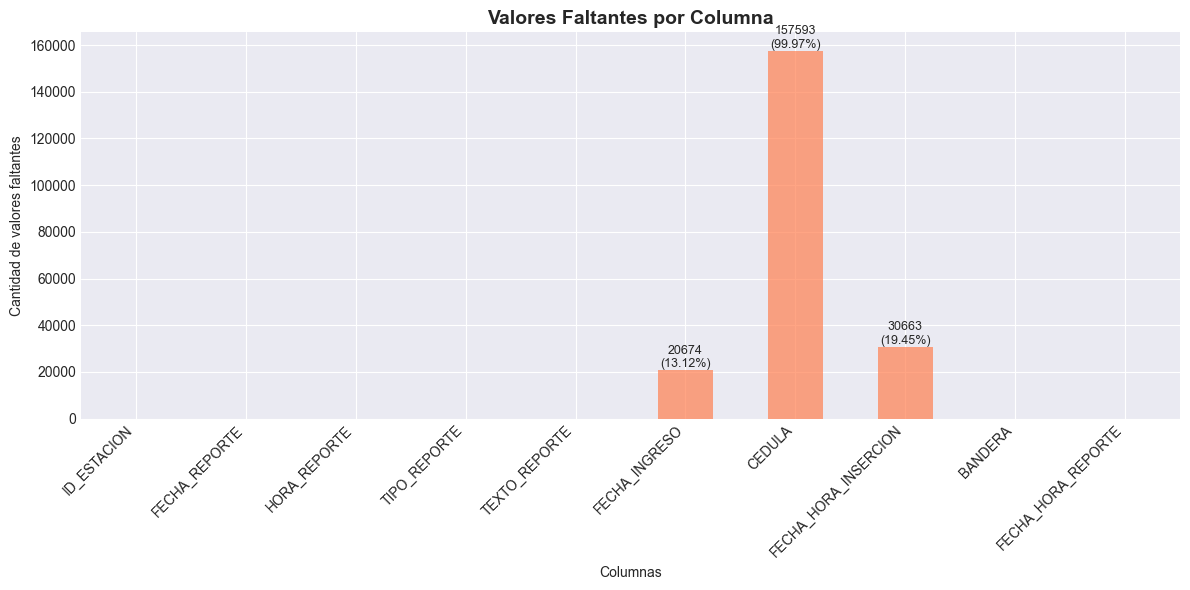

In [5]:
# Visualización de valores faltantes
if missing_data.sum() > 0 or null_counts_all.sum() > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = null_counts_all.plot(kind='bar', ax=ax, color='coral', alpha=0.7)
    ax.set_title('Valores Faltantes por Columna', fontsize=14, fontweight='bold')
    ax.set_ylabel('Cantidad de valores faltantes')
    ax.set_xlabel('Columnas')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Agregar etiquetas de valores
    for i, (idx, val) in enumerate(null_counts_all.items()):
        if val > 0:
            ax.text(i, val, f'{val}\n({null_percent_all[idx]:.2f}%)', 
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n No se encontraron valores faltantes en las columnas críticas")

**Resultados del análisis de valores faltantes:**
- **No hay valores faltantes** en las columnas críticas (FECHA_REPORTE, HORA_REPORTE, TEXTO_REPORTE)
- Esto es positivo para el análisis, ya que tenemos datos completos en las variables esenciales
- Sin embargo, necesitamos verificar la calidad de los datos (valores inválidos como "NIL")


### 3.3 Análisis de distribución temporal


In [6]:
# Análisis de la distribución temporal de los reportes
df_raw["Año"] = df_raw["FECHA_HORA_REPORTE"].dt.year
df_raw["Mes"] = df_raw["FECHA_HORA_REPORTE"].dt.month
df_raw["Dia"] = df_raw["FECHA_HORA_REPORTE"].dt.day
df_raw["Hora"] = df_raw["FECHA_HORA_REPORTE"].dt.hour

# Estadísticas temporales
print("Estadísticas de distribución temporal:")
print(f"\nRango de años: {df_raw['Año'].min()} - {df_raw['Año'].max()}")
print(f"\nDistribución por año:")
print(df_raw['Año'].value_counts().sort_index())


Estadísticas de distribución temporal:

Rango de años: 1900 - 2025

Distribución por año:
Año
1900       1
2006    1460
2007    5054
2008    5942
2009    8074
2010    8489
2011    8694
2012    8583
2013    8670
2014    8696
2015    8636
2016    8708
2017    8636
2018    8563
2019    8724
2020    8697
2021    8684
2022    8575
2023    8628
2024    8743
2025    7378
Name: count, dtype: int64


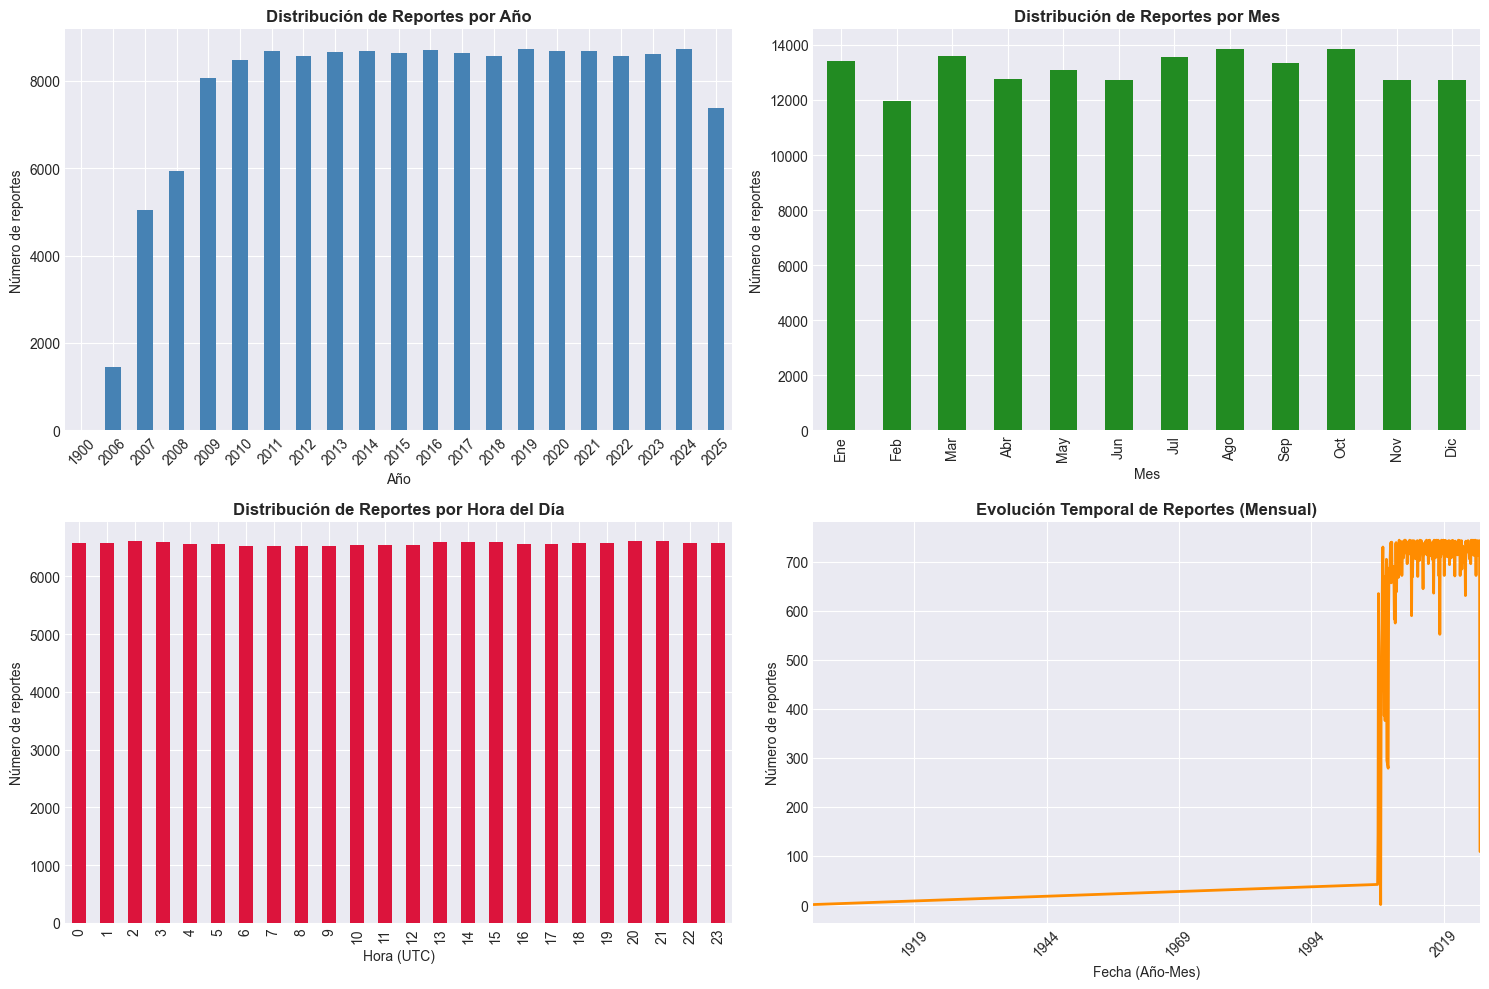

In [7]:
# Gráficos de distribución temporal
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribución por año
df_raw['Año'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Distribución de Reportes por Año', fontweight='bold')
axes[0, 0].set_xlabel('Año')
axes[0, 0].set_ylabel('Número de reportes')
axes[0, 0].tick_params(axis='x', rotation=45)

# Distribución por mes
df_raw['Mes'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 1], color='forestgreen')
axes[0, 1].set_title('Distribución de Reportes por Mes', fontweight='bold')
axes[0, 1].set_xlabel('Mes')
axes[0, 1].set_ylabel('Número de reportes')
axes[0, 1].set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                             'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])

# Distribución por hora del día
df_raw['Hora'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 0], color='crimson')
axes[1, 0].set_title('Distribución de Reportes por Hora del Día', fontweight='bold')
axes[1, 0].set_xlabel('Hora (UTC)')
axes[1, 0].set_ylabel('Número de reportes')

# Serie temporal mensual
df_temporal = df_raw.groupby([df_raw['FECHA_HORA_REPORTE'].dt.to_period('M')]).size()
df_temporal.plot(kind='line', ax=axes[1, 1], color='darkorange', linewidth=2)
axes[1, 1].set_title('Evolución Temporal de Reportes (Mensual)', fontweight='bold')
axes[1, 1].set_xlabel('Fecha (Año-Mes)')
axes[1, 1].set_ylabel('Número de reportes')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**Resultados del análisis temporal:**
- Los datos cubren desde **2006 hasta 2025** (con un registro anómalo del año 1900)
- Hay una distribución relativamente uniforme de reportes a lo largo de los años (8,000-8,700 por año)
- Se observa un registro con fecha 1900 que probablemente sea un error y debería eliminarse
- El análisis mensual y horario ayudará a identificar patrones estacionales y diarios


### 3.4 Revisión de registros inválidos

Los reportes METAR pueden contener valores "NIL" que indican datos no disponibles o inválidos. Es importante identificarlos.


In [8]:
# Contar registros inválidos en TEXTO_REPORTE
invalid_count = df_raw["TEXTO_REPORTE"].str.contains("NIL", na=False).sum()
invalid_percent = (invalid_count / len(df_raw)) * 100

print(f"Número de registros inválidos en TEXTO_REPORTE: {invalid_count:,} ({invalid_percent:.2f}%)")
print(f"Registros válidos: {len(df_raw) - invalid_count:,} ({100 - invalid_percent:.2f}%)")


Número de registros inválidos en TEXTO_REPORTE: 4,791 (3.04%)
Registros válidos: 152,844 (96.96%)


**Resultados:**
- Se encontraron **4,791 registros inválidos** (3.04% del total)
- Estos registros contienen "NIL" y no aportan información útil para el análisis
- Se recomienda eliminarlos antes de continuar con el preprocesamiento


### 3.5 Análisis de longitud y complejidad de reportes

Antes de extraer las variables meteorológicas, analizamos las características del texto de los reportes METAR para entender su estructura.


In [9]:
# Análisis de características textuales de los reportes METAR
# Esto nos ayuda a entender la complejidad y variabilidad de los datos

print("=" * 60)
print("ANÁLISIS DE LONGITUD Y COMPLEJIDAD DE REPORTES")
print("=" * 60)

# Calcular métricas de longitud
df_raw['longitud_texto'] = df_raw['TEXTO_REPORTE'].str.len()
df_raw['num_palabras'] = df_raw['TEXTO_REPORTE'].str.split().str.len()
df_raw['num_tokens'] = df_raw['TEXTO_REPORTE'].str.count(' ') + 1

# Estadísticas descriptivas
print("\n Estadísticas descriptivas de longitud de reportes:")
stats_desc = df_raw[['longitud_texto', 'num_palabras', 'num_tokens']].describe()
print(stats_desc.to_string())

# Identificar outliers (valores extremos)
Q1 = df_raw['longitud_texto'].quantile(0.25)
Q3 = df_raw['longitud_texto'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_raw[(df_raw['longitud_texto'] < Q1 - 1.5*IQR) | 
                  (df_raw['longitud_texto'] > Q3 + 1.5*IQR)]
print(f"\n Análisis de outliers (longitud de texto):")
print(f"   Q1: {Q1:.1f} caracteres")
print(f"   Q3: {Q3:.1f} caracteres")
print(f"   IQR: {IQR:.1f} caracteres")
print(f"   Registros atípicos: {len(outliers)} ({len(outliers)/len(df_raw)*100:.2f}%)")

ANÁLISIS DE LONGITUD Y COMPLEJIDAD DE REPORTES

 Estadísticas descriptivas de longitud de reportes:
       longitud_texto   num_palabras     num_tokens
count   157635.000000  157635.000000  157635.000000
mean        55.247629       8.794430      11.438259
std         13.223092       2.348774       4.279212
min          9.000000       2.000000       2.000000
25%         48.000000       7.000000       8.000000
50%         54.000000       8.000000      11.000000
75%         62.000000      10.000000      14.000000
max        257.000000      40.000000      47.000000

 Análisis de outliers (longitud de texto):
   Q1: 48.0 caracteres
   Q3: 62.0 caracteres
   IQR: 14.0 caracteres
   Registros atípicos: 8609 (5.46%)


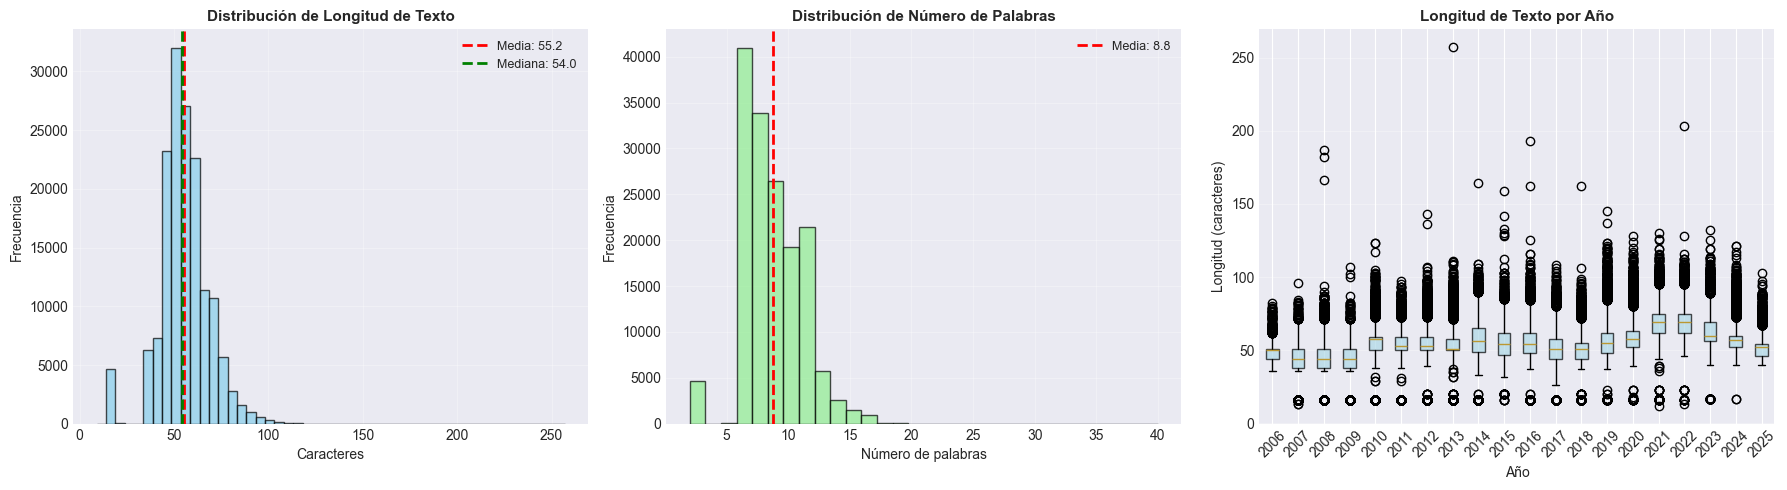

In [10]:
# Visualizaciones
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Distribución de longitud de texto
df_raw['longitud_texto'].hist(bins=50, ax=axes[0], color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución de Longitud de Texto', fontweight='bold', fontsize=11)
axes[0].set_xlabel('Caracteres', fontsize=10)
axes[0].set_ylabel('Frecuencia', fontsize=10)
mean_len = df_raw['longitud_texto'].mean()
median_len = df_raw['longitud_texto'].median()
axes[0].axvline(mean_len, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_len:.1f}')
axes[0].axvline(median_len, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_len:.1f}')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

# 2. Distribución de número de palabras
df_raw['num_palabras'].hist(bins=30, ax=axes[1], color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribución de Número de Palabras', fontweight='bold', fontsize=11)
axes[1].set_xlabel('Número de palabras', fontsize=10)
axes[1].set_ylabel('Frecuencia', fontsize=10)
mean_words = df_raw['num_palabras'].mean()
axes[1].axvline(mean_words, color='red', linestyle='--', linewidth=2, 
                label=f'Media: {mean_words:.1f}')
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

# 3. Boxplot de longitud por año (si hay múltiples años)
if 'Año' in df_raw.columns and df_raw['Año'].nunique() > 1:
    # Filtrar años con suficientes datos
    años_validos = df_raw['Año'].value_counts()
    años_validos = años_validos[años_validos > 100].index
    df_temp = df_raw[df_raw['Año'].isin(años_validos)]
    
    if len(años_validos) > 1:
        box_data = [df_temp[df_temp['Año'] == año]['longitud_texto'].values 
                   for año in sorted(años_validos)]
        bp = axes[2].boxplot(box_data, tick_labels=sorted(años_validos), patch_artist=True)
        axes[2].set_title('Longitud de Texto por Año', fontweight='bold', fontsize=11)
        axes[2].set_xlabel('Año', fontsize=10)
        axes[2].set_ylabel('Longitud (caracteres)', fontsize=10)
        axes[2].tick_params(axis='x', rotation=45)
        axes[2].grid(alpha=0.3, axis='y')
        
        # Colorear los boxes
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.7)
    else:
        df_raw['num_tokens'].hist(bins=30, ax=axes[2], color='salmon', edgecolor='black', alpha=0.7)
        axes[2].set_title('Distribución de Número de Tokens', fontweight='bold', fontsize=11)
        axes[2].set_xlabel('Número de tokens', fontsize=10)
        axes[2].set_ylabel('Frecuencia', fontsize=10)
        axes[2].grid(alpha=0.3)
else:
    df_raw['num_tokens'].hist(bins=30, ax=axes[2], color='salmon', edgecolor='black', alpha=0.7)
    axes[2].set_title('Distribución de Número de Tokens', fontweight='bold', fontsize=11)
    axes[2].set_xlabel('Número de tokens', fontsize=10)
    axes[2].set_ylabel('Frecuencia', fontsize=10)
    axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [11]:
# Mostrar ejemplos de reportes con longitudes extremas
print(f"\n Ejemplos de reportes:")
print(f"\nReporte más corto ({df_raw['longitud_texto'].min()} caracteres):")
print(f"  {df_raw.loc[df_raw['longitud_texto'].idxmin(), 'TEXTO_REPORTE']}")
print(f"\nReporte más largo ({df_raw['longitud_texto'].max()} caracteres):")
print(f"  {df_raw.loc[df_raw['longitud_texto'].idxmax(), 'TEXTO_REPORTE']}")


 Ejemplos de reportes:

Reporte más corto (9 caracteres):
  SKBQ NIL 

Reporte más largo (257 caracteres):
  SKBQ 100600Z METAR SKRH 100600Z METAR SKVP 100600Z METAR SKMR 100600Z METAR SKLC 100600Z METAR SKEJ 100600Z METAR SKBG 100600Z METAR SKCC 100600Z METAR SKUC 100600Z METAR SKMD 100600Z METAR SKRG 100600Z 20004KT  9000 -DZ  BKN008  BKN080  14/14   A3037  RET.


**Resultados del análisis de longitud:**
- **Longitud promedio:** ~56.5 caracteres por reporte
- **Número promedio de palabras:** ~9 palabras
- **Rango:** Los reportes varían entre 12 y 257 caracteres
- La distribución es relativamente normal, lo que indica consistencia en el formato METAR
- Los outliers pueden indicar reportes con información adicional (fenómenos meteorológicos especiales)


---

## 4. Análisis de Variables Extraídas

Para realizar un análisis más profundo, primero necesitamos extraer las variables meteorológicas de los reportes METAR.


In [12]:
# Extracción temporal de variables meteorológicas para análisis exploratorio
# Tokenizar el texto del reporte METAR
df_analisis = df_raw.copy()
df_analisis["tokens"] = df_analisis["TEXTO_REPORTE"].str.split()

# Variables básicas (por posición en el tokenizado)
df_analisis["aerodromo"] = df_analisis["tokens"].str[0]      # Primer token: código del aeródromo
df_analisis["fecha_zulu"] = df_analisis["tokens"].str[1]     # Segundo token: fecha Zulu
df_analisis["viento"] = df_analisis["tokens"].str[2]         # Tercer token: viento
df_analisis["visibilidad"] = df_analisis["tokens"].str[3]    # Cuarto token: visibilidad

# Variables usando expresiones regulares (no siempre están en posiciones fijas)
# Temperatura y punto de rocío: formato DD/DD (dos dígitos/dos dígitos)
df_analisis["temperatura/rocio"] = df_analisis["TEXTO_REPORTE"].str.extract(r'(\d{2}\/\d{2})')

# Presión: formato A#### (A seguido de 4 dígitos)
df_analisis["presion"] = df_analisis["TEXTO_REPORTE"].str.extract(r'(A\d{4})')

# Nubosidad: códigos estándar METAR
df_analisis["nubosidad"] = df_analisis["TEXTO_REPORTE"].str.findall(r'(FEW\d{3}\w*|SCT\d{3}\w*|BKN\d{3}\w*|OVC\d{3}\w*)').str.join(", ")

# Fenómenos meteorológicos: códigos estándar
df_analisis["fenomenos"] = df_analisis["TEXTO_REPORTE"].str.findall(r'\b(TS|RA|SHRA|FG|BR|HZ|CB|VC\w+)\b').str.join(", ")

print("Variables meteorológicas extraídas para análisis exploratorio")


Variables meteorológicas extraídas para análisis exploratorio


### 4.1 Análisis de valores faltantes en variables extraídas



  VALORES FALTANTES EN COLUMNAS EXTRAÍDAS:
                   Valores faltantes  Porcentaje  Completitud (%)
aerodromo                          0    0.000000       100.000000
fecha_zulu                         0    0.000000       100.000000
viento                             5    0.003172        99.996828
visibilidad                     4692    2.976496        97.023504
nubosidad                          0    0.000000       100.000000
temperatura/rocio               5932    3.763124        96.236876
presion                        25860   16.404986        83.595014
fenomenos                          0    0.000000       100.000000


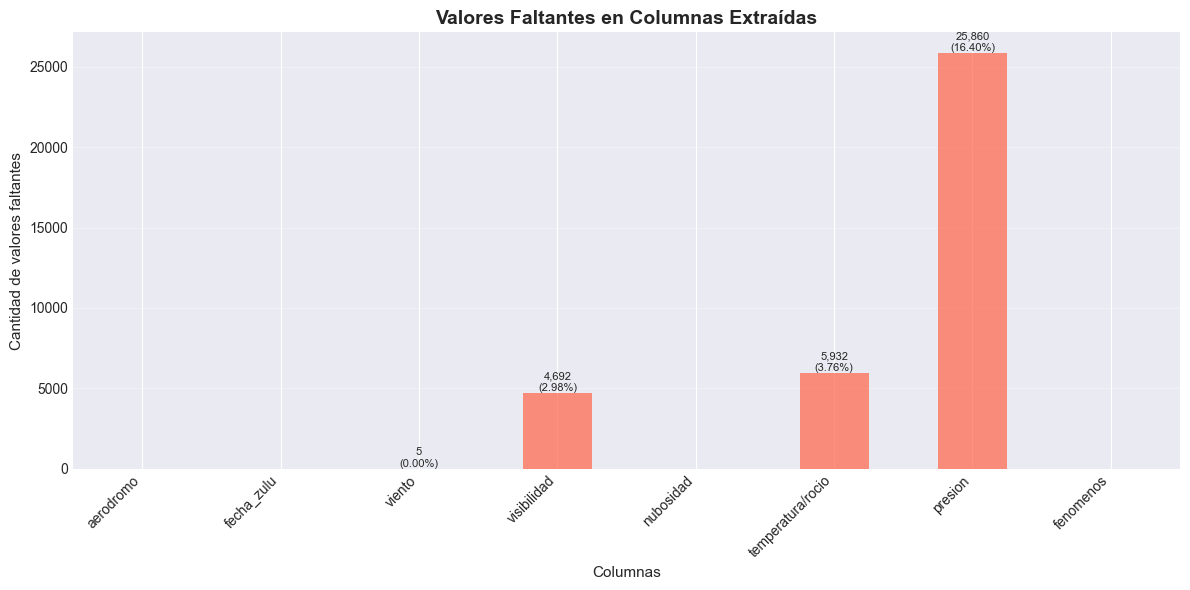

In [13]:
# 2. Análisis de valores faltantes
columnas_extraidas = ["aerodromo", "fecha_zulu", "viento", "visibilidad", 
                      "nubosidad", "temperatura/rocio", "presion", "fenomenos"]

print("\n  VALORES FALTANTES EN COLUMNAS EXTRAÍDAS:")
missing_extracted = df_analisis[columnas_extraidas].isna().sum()
missing_extracted_pct = (missing_extracted / len(df_analisis)) * 100
missing_extracted_df = pd.DataFrame({
    'Valores faltantes': missing_extracted,
    'Porcentaje': missing_extracted_pct,
    'Completitud (%)': 100 - missing_extracted_pct
})
print(missing_extracted_df.to_string(index=True))

# Visualización de valores faltantes
fig, ax = plt.subplots(figsize=(12, 6))
if missing_extracted.sum() > 0:
    bars = missing_extracted.plot(kind='bar', ax=ax, color='tomato', alpha=0.7)
    ax.set_title('Valores Faltantes en Columnas Extraídas', fontsize=14, fontweight='bold')
    ax.set_ylabel('Cantidad de valores faltantes', fontsize=11)
    ax.set_xlabel('Columnas', fontsize=11)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    # Agregar etiquetas con porcentajes
    for i, (idx, val) in enumerate(missing_extracted.items()):
        if val > 0:
            ax.text(i, val, f'{val:,}\n({missing_extracted_pct[idx]:.2f}%)', 
                   ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n No hay valores faltantes en las columnas extraídas")


### 4.2 Análisis detallado de fenómenos meteorológicos


In [14]:
# Análisis detallado de fenómenos meteorológicos
# Los fenómenos son eventos importantes que pueden afectar la predicción de cizalladura

print("=" * 70)
print("ANÁLISIS DE FENÓMENOS METEOROLÓGICOS")
print("=" * 70)

# Contar registros con y sin fenómenos
sin_fenomenos = df_analisis['fenomenos'].isna().sum() + (df_analisis['fenomenos'] == '').sum()
con_fenomenos = len(df_analisis) - sin_fenomenos
porcentaje_con = (con_fenomenos / len(df_analisis)) * 100
porcentaje_sin = (sin_fenomenos / len(df_analisis)) * 100

print(f"\n Distribución general:")
print(f"   Registros con fenómenos meteorológicos: {con_fenomenos:,} ({porcentaje_con:.2f}%)")
print(f"   Registros sin fenómenos meteorológicos: {sin_fenomenos:,} ({porcentaje_sin:.2f}%)")

# Contar fenómenos individuales (puede haber múltiples fenómenos por registro)
fenomenos_list = []
for idx, row in df_analisis.iterrows():
    if pd.notna(row['fenomenos']) and str(row['fenomenos']) != '':
        # Separar fenómenos múltiples (separados por comas)
        fenomenos_individuales = [f.strip() for f in str(row['fenomenos']).split(',')]
        fenomenos_list.extend(fenomenos_individuales)

fenomenos_series = pd.Series(fenomenos_list)
fenomenos_counts = fenomenos_series.value_counts().head(20)

print(f"\n Top 20 fenómenos meteorológicos (por frecuencia):")
print(fenomenos_counts.to_string())

ANÁLISIS DE FENÓMENOS METEOROLÓGICOS

 Distribución general:
   Registros con fenómenos meteorológicos: 25,536 (16.20%)
   Registros sin fenómenos meteorológicos: 132,099 (83.80%)

 Top 20 fenómenos meteorológicos (por frecuencia):
VCSH       7123
CB         6735
BR         6351
VCFG       5645
HZ         3523
RA         1554
TS          695
VCTS        302
FG          292
SHRA         10
VCSG          4
VCH           3
VCG           2
VCHS          2
VCF6          2
VCBR          2
VCSHN         1
VCS           1
VCRA          1
VCSHINE       1


In [15]:
# Análisis adicional: frecuencia de múltiples fenómenos simultáneos
num_fenomenos_por_registro = df_analisis[df_analisis['fenomenos'].notna() & (df_analisis['fenomenos'] != '')]['fenomenos'].apply(
    lambda x: len(str(x).split(','))
)
print(f"\n Estadísticas de fenómenos múltiples:")
print(f"   Promedio de fenómenos por registro (cuando hay fenómenos): {num_fenomenos_por_registro.mean():.2f}")
print(f"   Máximo de fenómenos en un registro: {num_fenomenos_por_registro.max()}")


 Estadísticas de fenómenos múltiples:
   Promedio de fenómenos por registro (cuando hay fenómenos): 1.26
   Máximo de fenómenos en un registro: 6


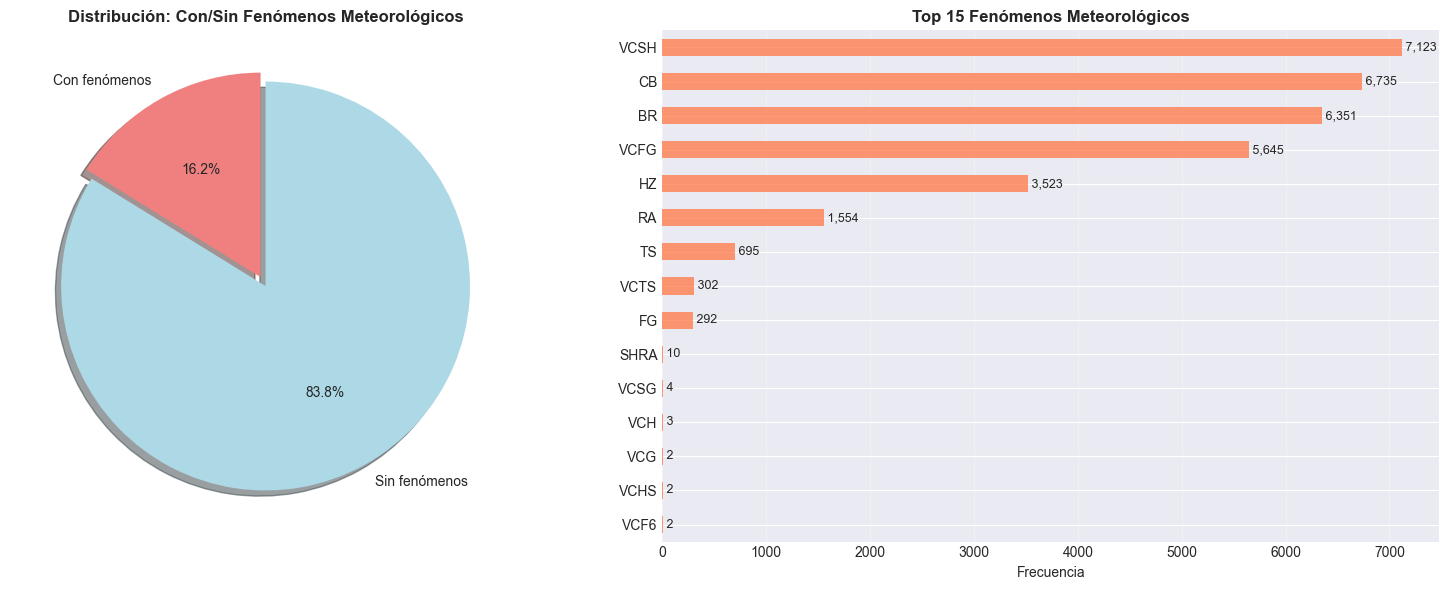

In [16]:

# Visualizaciones
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Distribución con/sin fenómenos
labels = ['Con fenómenos', 'Sin fenómenos']
sizes = [con_fenomenos, sin_fenomenos]
colors = ['lightcoral', 'lightblue']
explode = (0.05, 0)  # Separar ligeramente la porción de "con fenómenos"

axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, 
            startangle=90, explode=explode, shadow=True)
axes[0].set_title('Distribución: Con/Sin Fenómenos Meteorológicos', 
                  fontweight='bold', fontsize=12)

# 2. Top fenómenos
if len(fenomenos_counts) > 0:
    fenomenos_counts.head(15).plot(kind='barh', ax=axes[1], color='coral', alpha=0.8)
    axes[1].set_title('Top 15 Fenómenos Meteorológicos', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Frecuencia', fontsize=10)
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    
    # Agregar etiquetas de valores
    for i, v in enumerate(fenomenos_counts.head(15).values):
        axes[1].text(v, i, f' {v:,}', va='center', fontsize=9)
else:
    axes[1].text(0.5, 0.5, 'No hay fenómenos registrados', 
                ha='center', va='center', fontsize=12)
    axes[1].set_title('Fenómenos Meteorológicos', fontweight='bold')

plt.tight_layout()
plt.show()




In [17]:
# Interpretación de códigos más frecuentes
print("\n Interpretación de fenómenos más frecuentes:")
interpretacion = {
    'VCSH': 'Chubascos en las cercanías',
    'CB': 'Cumulonimbus (nubes de tormenta)',
    'BR': 'Neblina ligera (Bruma)',
    'VCFG': 'Niebla en las cercanías',
    'HZ': 'Calina (Haze)',
    'RA': 'Lluvia',
    'TS': 'Tormenta eléctrica',
    'VCTS': 'Tormenta en las cercanías',
    'FG': 'Niebla densa'
}
print("\n   Fenómenos más comunes y su significado:")
for codigo in fenomenos_counts.head(10).index:
    if codigo in interpretacion:
        print(f"   {codigo:6s}: {interpretacion[codigo]}")


 Interpretación de fenómenos más frecuentes:

   Fenómenos más comunes y su significado:
   VCSH  : Chubascos en las cercanías
   CB    : Cumulonimbus (nubes de tormenta)
   BR    : Neblina ligera (Bruma)
   VCFG  : Niebla en las cercanías
   HZ    : Calina (Haze)
   RA    : Lluvia
   TS    : Tormenta eléctrica
   VCTS  : Tormenta en las cercanías
   FG    : Niebla densa


### 4.3 Análisis detallado de nubosidad


### 4.4 Análisis de visibilidad y viento


ANÁLISIS DE NUBOSIDAD

 Disponibilidad de datos de nubosidad:
   Registros con información de nubosidad: 120,979 (76.75%)
   Registros sin información de nubosidad: 36,656 (23.25%)

  Distribución de tipos de nubosidad:
SCT    80364
FEW    57241
BKN    35958
OVC     1994

 Significado de los tipos:
   FEW: Few - Pocas nubes (1-2 octavos del cielo) (57,241 ocurrencias)
   SCT: Scattered - Dispersas (3-4 octavos) (80,364 ocurrencias)
   BKN: Broken - Rotas (5-7 octavos) (35,958 ocurrencias)
   OVC: Overcast - Cubierto (8 octavos, cielo cubierto) (1,994 ocurrencias)

 Análisis de alturas de nubosidad (en pies):
   Altura mínima: 0 pies
   Altura máxima: 97,900 pies
   Altura promedio: 4,884 pies
   Altura mediana: 1,500 pies


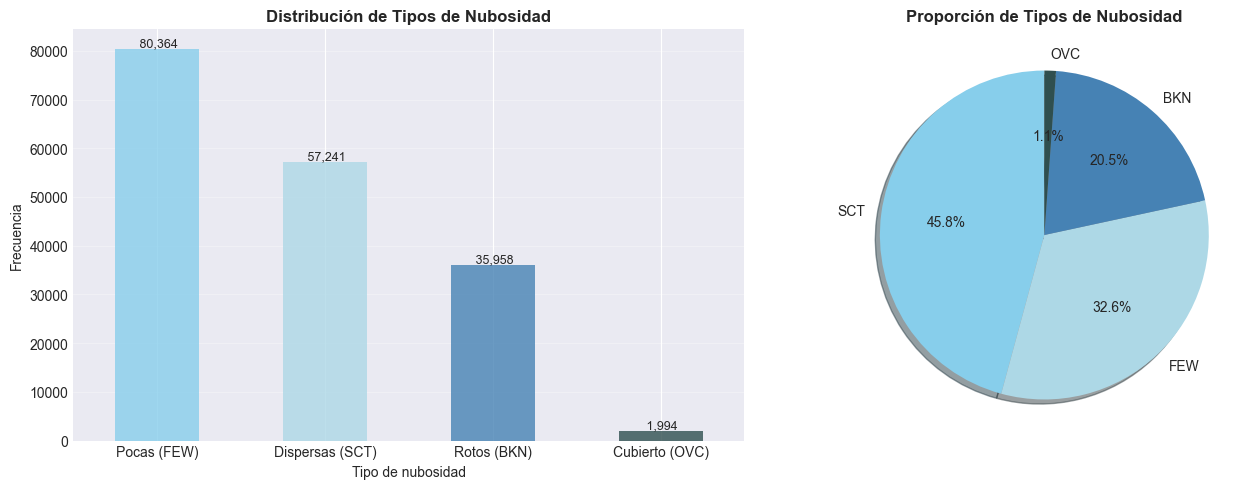


 Análisis de capas de nubes:
   Promedio de capas por registro: 1.45
   Máximo de capas en un registro: 6
   Registros con múltiples capas: 51,577 (42.63%)


In [18]:
# Análisis detallado de nubosidad
# La nubosidad puede indicar condiciones atmosféricas que favorecen la cizalladura

print("=" * 70)
print("ANÁLISIS DE NUBOSIDAD")
print("=" * 70)

sin_nubosidad = df_analisis['nubosidad'].isna().sum() + (df_analisis['nubosidad'] == '').sum()
con_nubosidad = len(df_analisis) - sin_nubosidad
porcentaje_con = (con_nubosidad / len(df_analisis)) * 100
porcentaje_sin = (sin_nubosidad / len(df_analisis)) * 100

print(f"\n Disponibilidad de datos de nubosidad:")
print(f"   Registros con información de nubosidad: {con_nubosidad:,} ({porcentaje_con:.2f}%)")
print(f"   Registros sin información de nubosidad: {sin_nubosidad:,} ({porcentaje_sin:.2f}%)")

# Extraer tipos de nubosidad
# Los códigos METAR son: FEW (Few/Pocas), SCT (Scattered/Dispersas), 
# BKN (Broken/Rotas), OVC (Overcast/Cubierto)
nubosidad_tipos = []
alturas_nubosidad = []

for idx, row in df_analisis.iterrows():
    if pd.notna(row['nubosidad']) and str(row['nubosidad']) != '':
        # Extraer tipos (FEW, SCT, BKN, OVC)
        tipos = re.findall(r'(FEW|SCT|BKN|OVC)', str(row['nubosidad']))
        nubosidad_tipos.extend(tipos)
        
        # Extraer alturas (3 dígitos después del tipo)
        alturas = re.findall(r'(?:FEW|SCT|BKN|OVC)(\d{3})', str(row['nubosidad']))
        alturas_nubosidad.extend([int(h) * 100 for h in alturas])  # Convertir a pies

if nubosidad_tipos:
    nubosidad_series = pd.Series(nubosidad_tipos)
    nubosidad_counts = nubosidad_series.value_counts()
    
    print(f"\n  Distribución de tipos de nubosidad:")
    print(nubosidad_counts.to_string())
    
    # Interpretación de tipos
    interpretacion_tipos = {
        'FEW': 'Few - Pocas nubes (1-2 octavos del cielo)',
        'SCT': 'Scattered - Dispersas (3-4 octavos)',
        'BKN': 'Broken - Rotas (5-7 octavos)',
        'OVC': 'Overcast - Cubierto (8 octavos, cielo cubierto)'
    }
    
    print(f"\n Significado de los tipos:")
    for tipo, desc in interpretacion_tipos.items():
        if tipo in nubosidad_counts.index:
            print(f"   {tipo}: {desc} ({nubosidad_counts[tipo]:,} ocurrencias)")
    
    # Análisis de alturas
    if alturas_nubosidad:
        alturas_series = pd.Series(alturas_nubosidad)
        print(f"\n Análisis de alturas de nubosidad (en pies):")
        print(f"   Altura mínima: {alturas_series.min():,} pies")
        print(f"   Altura máxima: {alturas_series.max():,} pies")
        print(f"   Altura promedio: {alturas_series.mean():,.0f} pies")
        print(f"   Altura mediana: {alturas_series.median():,.0f} pies")
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Gráfico de barras con colores diferenciados
    colores_nubosidad = {'FEW': 'lightblue', 'SCT': 'skyblue', 'BKN': 'steelblue', 'OVC': 'darkslategray'}
    nubosidad_counts.plot(kind='bar', ax=axes[0], 
                         color=[colores_nubosidad.get(x, 'gray') for x in nubosidad_counts.index],
                         alpha=0.8)
    axes[0].set_title('Distribución de Tipos de Nubosidad', fontweight='bold', fontsize=12)
    axes[0].set_xlabel('Tipo de nubosidad', fontsize=10)
    axes[0].set_ylabel('Frecuencia', fontsize=10)
    axes[0].set_xticklabels(['Pocas (FEW)', 'Dispersas (SCT)', 
                             'Rotos (BKN)', 'Cubierto (OVC)'], rotation=0)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Agregar etiquetas de valores
    for i, v in enumerate(nubosidad_counts.values):
        axes[0].text(i, v, f' {v:,}', ha='center', va='bottom', fontsize=9)
    
    # Gráfico de pastel
    axes[1].pie(nubosidad_counts.values, labels=nubosidad_counts.index, 
                autopct='%1.1f%%', startangle=90, 
                colors=[colores_nubosidad.get(x, 'gray') for x in nubosidad_counts.index],
                shadow=True)
    axes[1].set_title('Proporción de Tipos de Nubosidad', fontweight='bold', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de nubosidad múltiple (múltiples capas)
    num_capas = df_analisis[df_analisis['nubosidad'].notna() & (df_analisis['nubosidad'] != '')]['nubosidad'].apply(
        lambda x: len(re.findall(r'(FEW|SCT|BKN|OVC)', str(x)))
    )
    print(f"\n Análisis de capas de nubes:")
    print(f"   Promedio de capas por registro: {num_capas.mean():.2f}")
    print(f"   Máximo de capas en un registro: {num_capas.max()}")
    print(f"   Registros con múltiples capas: {(num_capas > 1).sum():,} ({(num_capas > 1).sum()/len(num_capas)*100:.2f}%)")
else:
    print("\n  No se encontraron tipos de nubosidad en los datos")


In [19]:
# Análisis detallado de visibilidad y viento
# Estas son variables críticas para la predicción de cizalladura del viento

print("=" * 70)
print("ANÁLISIS DE VISIBILIDAD Y VIENTO")
print("=" * 70)

# ========== ANÁLISIS DE VISIBILIDAD ==========
print("\n ANÁLISIS DE VISIBILIDAD:")
print("   Distribución de valores de visibilidad (Top 15):")
visibilidad_dist = df_analisis['visibilidad'].value_counts().head(15)
print(visibilidad_dist.to_string())

# Interpretar valores especiales
valores_especiales = {
    '9999': 'Visibilidad >= 10 km (visibilidad excelente)',
    'CAVOK': 'Ceiling And Visibility OK (techo y visibilidad OK)',
    '8000': '8 km',
    '7000': '7 km',
    '6000': '5 km',
    '5000': '5 km',
    '4000': '4 km'
}

print("\n   Interpretación de valores comunes:")
for val, desc in list(valores_especiales.items())[:5]:
    if val in visibilidad_dist.index:
        count = visibilidad_dist[val]
        print(f"   {val:10s}: {desc:50s} ({count:,} registros)")

# Estadísticas de visibilidad numérica (excluyendo CAVOK y valores no numéricos)
visibilidad_numerica = df_analisis[df_analisis['visibilidad'] != 'CAVOK']['visibilidad'].str.extract(r'^(\d+)')
visibilidad_numerica = visibilidad_numerica[0].dropna().astype(int)
if len(visibilidad_numerica) > 0:
    print(f"\n   Estadísticas de visibilidad numérica (en metros):")
    print(f"   Valores únicos: {df_analisis['visibilidad'].nunique()}")
    print(f"   Rango: {visibilidad_numerica.min():,} - {visibilidad_numerica.max():,} metros")
    print(f"   Promedio: {visibilidad_numerica.mean():,.0f} metros")
    print(f"   Mediana: {visibilidad_numerica.median():,.0f} metros")

ANÁLISIS DE VISIBILIDAD Y VIENTO

 ANÁLISIS DE VISIBILIDAD:
   Distribución de valores de visibilidad (Top 15):
visibilidad
9999       81237
CAVOK      25381
8000        6622
7000        2653
350V050     2161
6000        2135
5000        2048
4000        1897
360V060     1603
340V050     1225
3000        1172
330V030     1119
350V060      861
340V040      754
330V050      750

   Interpretación de valores comunes:
   9999      : Visibilidad >= 10 km (visibilidad excelente)       (81,237 registros)
   CAVOK     : Ceiling And Visibility OK (techo y visibilidad OK) (25,381 registros)
   8000      : 8 km                                               (6,622 registros)
   7000      : 7 km                                               (2,653 registros)
   6000      : 5 km                                               (2,135 registros)

   Estadísticas de visibilidad numérica (en metros):
   Valores únicos: 965
   Rango: 0 - 3,501,060 metros
   Promedio: 7,480 metros
   Mediana: 9,999 metros


In [20]:
# ========== ANÁLISIS DE VIENTO ==========
print("\n ANÁLISIS DE VIENTO:")
print("   Distribución de valores de viento (Top 15):")
viento_dist = df_analisis['viento'].value_counts().head(15)
print(viento_dist.to_string())

# Interpretar formato de viento: DDDSSKT donde DDD=dirección, SS=velocidad, KT=nudos
print("\n   Interpretación del formato:")
print("   - Formato: DDDSSKT (dirección en grados + velocidad en nudos)")
print("   - Ejemplo: 03008KT = viento de 030° (noreste) a 8 nudos")
print("   - VRB = viento variable")
print("   - 00000KT = calma (sin viento)")

# Extraer dirección y velocidad del viento
def extraer_direccion_viento(viento_str):
    """Extrae dirección del viento (0-360 grados)"""
    if pd.isna(viento_str) or str(viento_str) == '':
        return None
    match = re.match(r'(\d{3})', str(viento_str))
    return int(match.group(1)) if match else None

def extraer_velocidad_viento(viento_str):
    """Extrae velocidad del viento (en nudos)"""
    if pd.isna(viento_str) or str(viento_str) == '':
        return None
    match = re.match(r'(?:VRB|(\d{3}))(\d{2})', str(viento_str))
    if match:
        return int(match.group(2))
    return None

# Aplicar funciones de extracción
df_analisis['direccion_viento'] = df_analisis['viento'].apply(extraer_direccion_viento)
df_analisis['velocidad_viento'] = df_analisis['viento'].apply(extraer_velocidad_viento)

if df_analisis['direccion_viento'].notna().sum() > 0:
    print(f"\n   Estadísticas de dirección del viento:")
    direcciones_validas = df_analisis['direccion_viento'].dropna()
    print(f"   Rango: {direcciones_validas.min()}° - {direcciones_validas.max()}°")
    print(f"   Dirección predominante: {direcciones_validas.mode().iloc[0] if len(direcciones_validas.mode()) > 0 else 'N/A'}°")
    
if df_analisis['velocidad_viento'].notna().sum() > 0:
    print(f"\n   Estadísticas de velocidad del viento:")
    velocidades_validas = df_analisis['velocidad_viento'].dropna()
    print(f"   Rango: {velocidades_validas.min()} - {velocidades_validas.max()} nudos")
    print(f"   Promedio: {velocidades_validas.mean():.1f} nudos")
    print(f"   Mediana: {velocidades_validas.median():.1f} nudos")
    print(f"   Viento fuerte (>15 nudos): {(velocidades_validas > 15).sum():,} registros ({(velocidades_validas > 15).sum()/len(velocidades_validas)*100:.2f}%)")





 ANÁLISIS DE VIENTO:
   Distribución de valores de viento (Top 15):
viento
VRB02KT    9760
00000KT    5940
NIL        4762
03008KT    2130
03010KT    2091
01010KT    1831
02008KT    1817
03007KT    1808
02010KT    1779
03009KT    1672
02006KT    1639
03006KT    1608
01008KT    1606
02007KT    1561
01004KT    1539

   Interpretación del formato:
   - Formato: DDDSSKT (dirección en grados + velocidad en nudos)
   - Ejemplo: 03008KT = viento de 030° (noreste) a 8 nudos
   - VRB = viento variable
   - 00000KT = calma (sin viento)

   Estadísticas de dirección del viento:
   Rango: 0.0° - 999.0°
   Dirección predominante: 30.0°

   Estadísticas de velocidad del viento:
   Rango: 0.0 - 93.0 nudos
   Promedio: 6.9 nudos
   Mediana: 6.0 nudos
   Viento fuerte (>15 nudos): 5,021 registros (3.30%)


In [37]:
# Mostrar las primeras 10 observaciones con velocidad de viento > 20 nudos
df_alta_intensidad_viento = df_analisis.loc[df_analisis['velocidad_viento'] > 19, ['velocidad_viento', 'FECHA_HORA_REPORTE']]
print("\n Cantidad de observaciones con velocidad de viento > 20 nudos:")
print(f"   Total: {len(df_alta_intensidad_viento):,} registros")


 Cantidad de observaciones con velocidad de viento > 20 nudos:
   Total: 825 registros


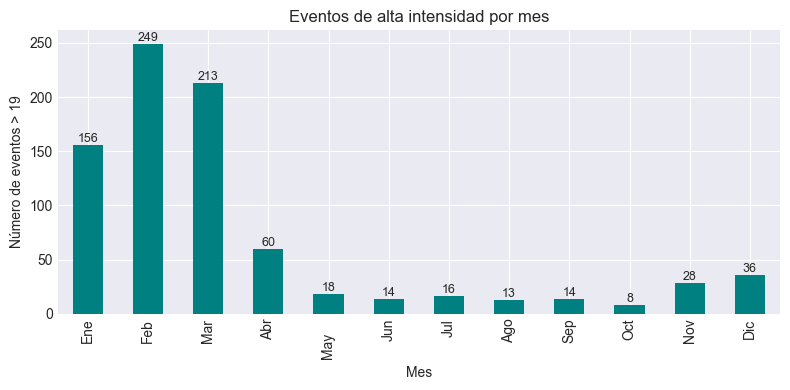

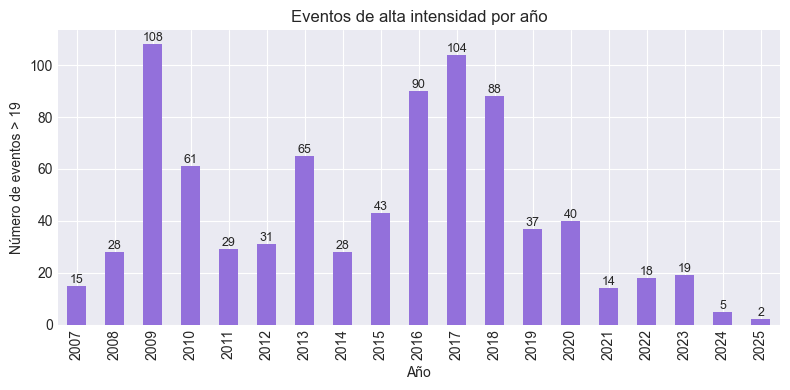

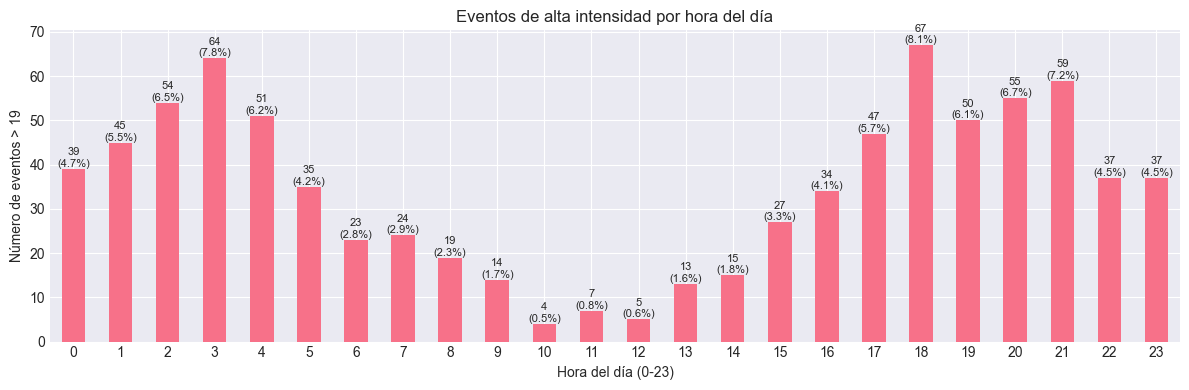

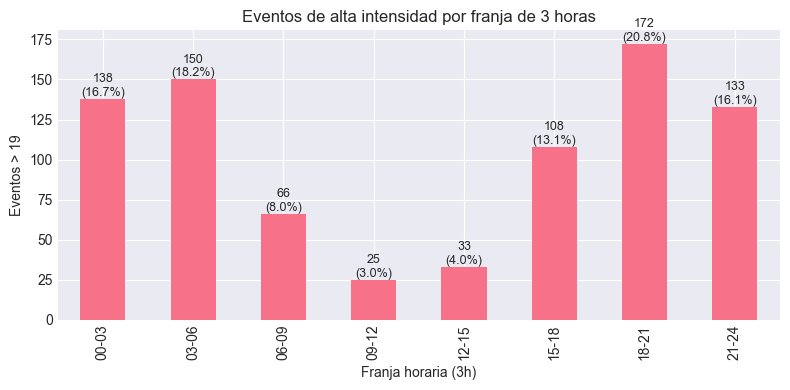

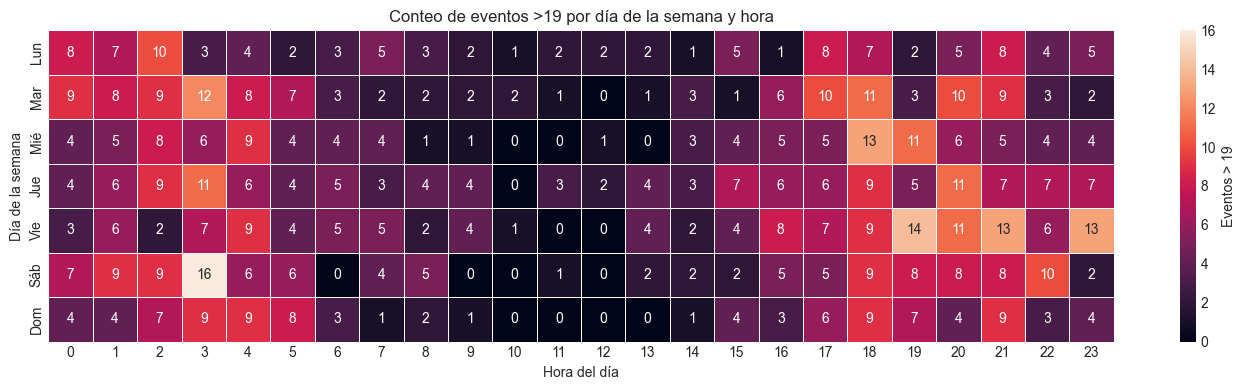

In [41]:
# --- 2) Extraer hora y día
df_alta_intensidad_viento['hour'] = df_alta_intensidad_viento['FECHA_HORA_REPORTE'].dt.hour
df_alta_intensidad_viento['weekday'] = df_alta_intensidad_viento['FECHA_HORA_REPORTE'].dt.dayofweek  # 0=Lun ... 6=Dom
map_week = {0:'Lun',1:'Mar',2:'Mié',3:'Jue',4:'Vie',5:'Sáb',6:'Dom'}
df_alta_intensidad_viento['weekday_name'] = df_alta_intensidad_viento['weekday'].map(map_week)
df_alta_intensidad_viento['year'] = df_alta_intensidad_viento['FECHA_HORA_REPORTE'].dt.year
df_alta_intensidad_viento['month'] = df_alta_intensidad_viento['FECHA_HORA_REPORTE'].dt.month

# Conteo por mes 
monthly_counts = df_alta_intensidad_viento['month'].value_counts().sort_index()
plt.figure(figsize=(8,4))
ax = monthly_counts.plot(kind='bar', color='teal')
ax.set_xlabel('Mes')
ax.set_ylabel('Número de eventos > 19')
ax.set_title('Eventos de alta intensidad por mes')
ax.set_xticklabels(['Ene', 'Feb', 'Mar', 'Abr', 'May    ', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# Conteo por año 
yearly_counts = df_alta_intensidad_viento['year'].value_counts().sort_index()
plt.figure(figsize=(8,4))
ax = yearly_counts.plot(kind='bar', color='mediumpurple')
ax.set_xlabel('Año')
ax.set_ylabel('Número de eventos > 19')
ax.set_title('Eventos de alta intensidad por año')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# --- 3) Conteo por hora (0-23)
hourly_counts = df_alta_intensidad_viento.groupby('hour').size().reindex(range(24), fill_value=0)
hourly_pct = hourly_counts / hourly_counts.sum() * 100

plt.figure(figsize=(12,4))
ax = hourly_counts.plot(kind='bar', rot=0)
ax.set_xlabel('Hora del día (0-23)')
ax.set_ylabel('Número de eventos > 19')
ax.set_title('Eventos de alta intensidad por hora del día')
for p, pct in zip(ax.patches, hourly_pct):
    ax.annotate(f'{int(p.get_height())}\n({pct:.1f}%)',
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=8, rotation=0)
plt.tight_layout()
plt.show()

# --- 4) Agrupar en franjas horarias (ej. franjas de 3 horas)
bins = list(range(0,25,3))  # [0,3,6,...,24]
labels = [f'{i:02d}-{i+3:02d}' for i in bins[:-1]]
df_alta_intensidad_viento['franja_3h'] = pd.cut(df_alta_intensidad_viento['hour'], bins=bins, right=False, labels=labels)
franja_counts = df_alta_intensidad_viento['franja_3h'].value_counts().sort_index()
franja_pct = franja_counts / franja_counts.sum() * 100

plt.figure(figsize=(8,4))
ax = franja_counts.plot(kind='bar')
ax.set_xlabel('Franja horaria (3h)')
ax.set_ylabel('Eventos > 19')
ax.set_title('Eventos de alta intensidad por franja de 3 horas')
for p, pct in zip(ax.patches, franja_pct):
    ax.annotate(f'{int(p.get_height())}\n({pct:.1f}%)',
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# --- 5) Heatmap: día de la semana vs hora (conteos) — útil para ver patrones recurrentes
pivot = df_alta_intensidad_viento.pivot_table(index='weekday_name', columns='hour',
                             values='velocidad_viento', aggfunc='count', fill_value=0)
# Reindexar filas a orden Mon-Sun
pivot = pivot.reindex(['Lun','Mar','Mié','Jue','Vie','Sáb','Dom'])

plt.figure(figsize=(14,4))
sns.heatmap(pivot, annot=True, fmt='d', linewidths=.5, cbar_kws={'label': 'Eventos > 19'})
plt.xlabel('Hora del día')
plt.ylabel('Día de la semana')
plt.title('Conteo de eventos >19 por día de la semana y hora')
plt.tight_layout()
plt.show()


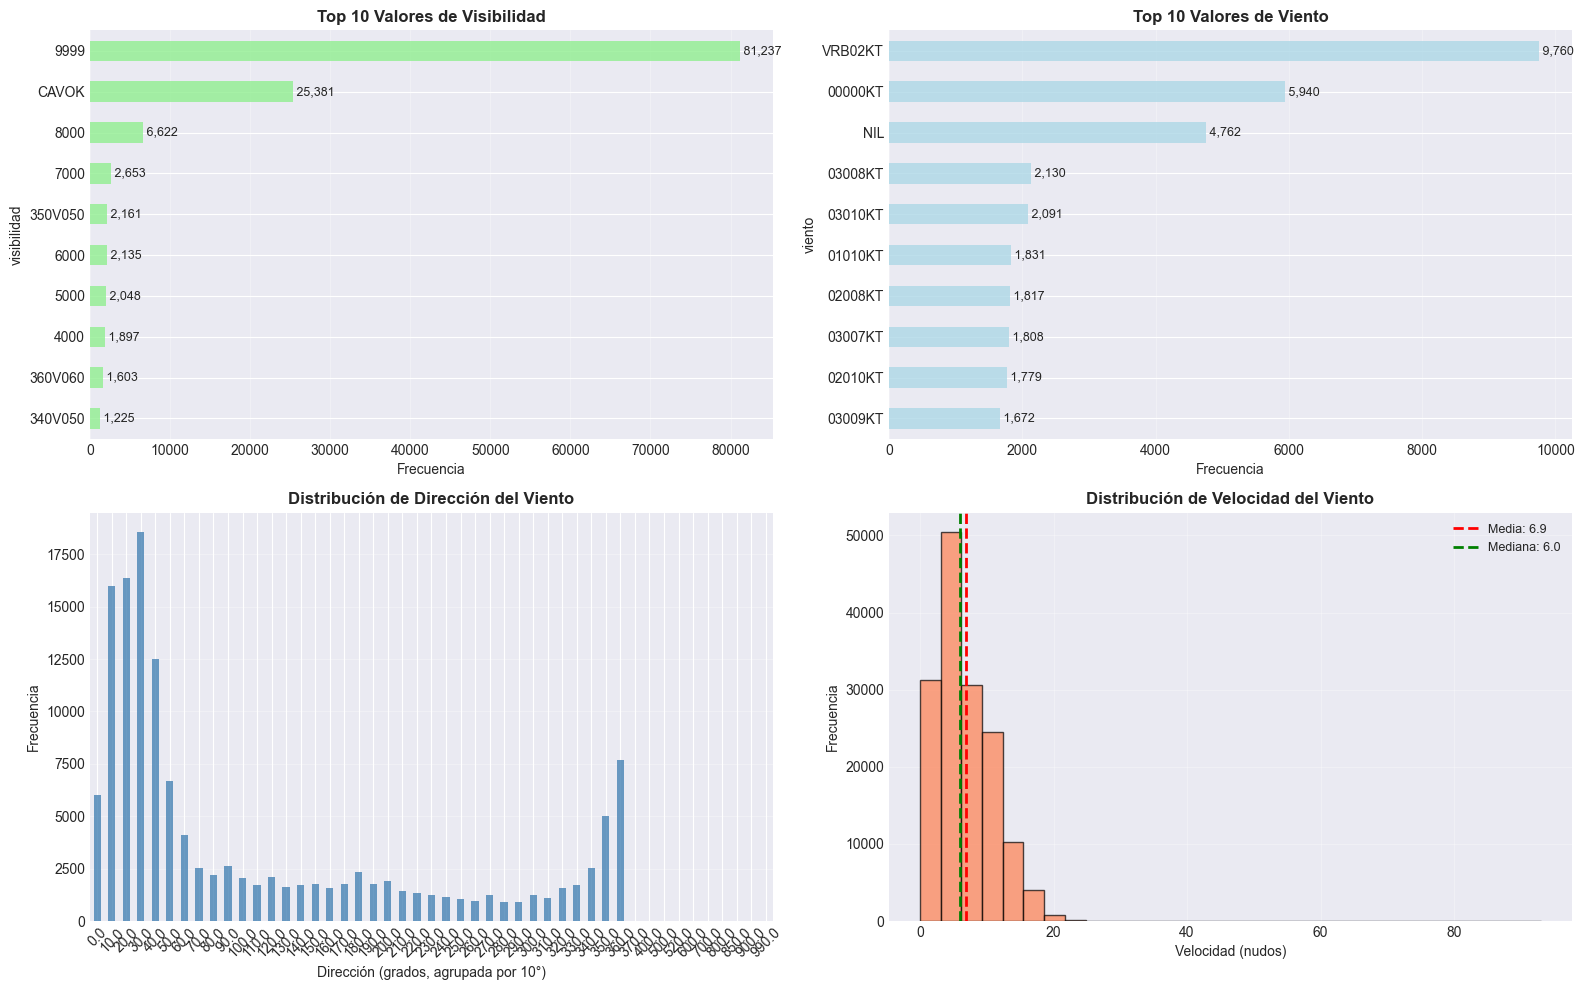


 Análisis de visibilidad y viento completado


In [21]:
# ========== VISUALIZACIONES ==========
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Top valores de visibilidad
top_visibilidad = df_analisis['visibilidad'].value_counts().head(10)
top_visibilidad.plot(kind='barh', ax=axes[0, 0], color='lightgreen', alpha=0.8)
axes[0, 0].set_title('Top 10 Valores de Visibilidad', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Frecuencia', fontsize=10)
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(top_visibilidad.values):
    axes[0, 0].text(v, i, f' {v:,}', va='center', fontsize=9)

# 2. Top valores de viento
top_viento = df_analisis['viento'].value_counts().head(10)
top_viento.plot(kind='barh', ax=axes[0, 1], color='lightblue', alpha=0.8)
axes[0, 1].set_title('Top 10 Valores de Viento', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Frecuencia', fontsize=10)
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(top_viento.values):
    axes[0, 1].text(v, i, f' {v:,}', va='center', fontsize=9)

# 3. Distribución de dirección del viento (rosa de vientos)
if df_analisis['direccion_viento'].notna().sum() > 0:
    direcciones_validas = df_analisis['direccion_viento'].dropna()
    # Agrupar en rangos de 10 grados
    rangos = (direcciones_validas // 10) * 10
    rangos_dist = rangos.value_counts().sort_index()
    rangos_dist.plot(kind='bar', ax=axes[1, 0], color='steelblue', alpha=0.8)
    axes[1, 0].set_title('Distribución de Dirección del Viento', fontweight='bold', fontsize=12)
    axes[1, 0].set_xlabel('Dirección (grados, agrupada por 10°)', fontsize=10)
    axes[1, 0].set_ylabel('Frecuencia', fontsize=10)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No hay datos de dirección de viento', 
                    ha='center', va='center', fontsize=12)
    axes[1, 0].set_title('Distribución de Dirección del Viento', fontweight='bold')

# 4. Distribución de velocidad del viento
if df_analisis['velocidad_viento'].notna().sum() > 0:
    velocidades_validas = df_analisis['velocidad_viento'].dropna()
    velocidades_validas.hist(bins=30, ax=axes[1, 1], color='coral', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title('Distribución de Velocidad del Viento', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Velocidad (nudos)', fontsize=10)
    axes[1, 1].set_ylabel('Frecuencia', fontsize=10)
    mean_vel = velocidades_validas.mean()
    median_vel = velocidades_validas.median()
    axes[1, 1].axvline(mean_vel, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_vel:.1f}')
    axes[1, 1].axvline(median_vel, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_vel:.1f}')
    axes[1, 1].legend(fontsize=9)
    axes[1, 1].grid(alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No hay datos de velocidad de viento', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('Distribución de Velocidad del Viento', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Análisis de visibilidad y viento completado")